In [1]:
!CUDA_VISIBLE_DEVICE=0

In [2]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import anndata as ad
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
from scipy import stats
import torch
import sys
sys.path.append('..')
from VAE.VAE_model import VAE
import celltypist

In [109]:
def load_VAE():
    autoencoder = VAE(
        num_genes=19423,
        device='cuda',
        seed=0,
        loss_ae='mse',
        hidden_dim=128,
        decoder_activation='ReLU',
    )
    autoencoder.load_state_dict(torch.load('/data1/lep/Workspace/guided-diffusion/VAE/checkpoint/WOT_no3540_scimilarity_lognorm_finetune/model_seed=0_step=150000.pt'))
    return autoencoder

load real data

In [5]:
# load WOT dataset
ori_adata = sc.read_h5ad('/data1/lep/Workspace/guided-diffusion/data/WOT/filted_data.h5ad')
ori_adata = ori_adata[np.where(np.in1d(ori_adata.obs['period'], ['D0','D0.5','D1','D1.5','D2','D2.5','D3','D3.5','D4','D4.5','D5','D5.5','D6','D6.5','D7','D7.5','D8']))[0]]#[::15]
tmp_ = sc.read_10x_h5('/data1/lep/Workspace/guided-diffusion/data/WOT/GSM3195672_D6_Dox_C1_gene_bc_mat.h5')
ori_adata.var_names_make_unique()
gene_names = tmp_.var_names[ori_adata.var_names.astype(np.int32)]
sc.pp.normalize_total(ori_adata, target_sum=1e4)
sc.pp.log1p(ori_adata)
ori_celltype = ori_adata.obs['period']

In [110]:
adata = ori_adata.copy()
adata.var_names = gene_names

adata = adata[np.where(np.in1d(adata.obs['period'], ['D1.5','D2','D2.5','D3','D3.5','D4','D4.5','D5','D5.5','D6']))[0]][::5]

gene_names = adata.var_names
adata.var_names_make_unique()
celltype = adata.obs['period']#[::5]
cell_data = adata.X#[::5]

cell_data.shape

(13836, 19423)

use other cells to balance the batch norm in scimilarity

In [121]:
adata_w = ori_adata.copy()
adata_w.var_names = gene_names
adata_w = adata_w[np.where(np.in1d(adata_w.obs['period'], ['D2','D2.5','D3','D3.5','D4','D4.5','D5','D5.5','D6','D6.5','D7','D7.5','D8']))[0]][::15]
# adata_w = adata_w[np.where(np.in1d(adata_w.obs['period'], ['D0','D0.5','D1','D1.5']))[0]][::15]

autoencoder = load_VAE()
cell_w = autoencoder(torch.tensor(adata_w.X).cuda(),return_latent=True).detach().cpu().numpy()

cell_w.shape

(5722, 128)

In [122]:
# load generated cells with different Gradient Interpolations
stage_list = [str(i) for i in np.array(range(1,20))/2]
cell_gen = []
cell_stage = []
cell_dis = []

for i in range(11):#index2:
    npzfile=np.load(f'/data1/lep/Workspace/guided-diffusion/output/inter_wot_D3540/inter_{10-i}_{i}_scimilarity2.npz',allow_pickle=True)
    # npzfile=np.load(f'/data1/lep/Workspace/guided-diffusion/output/wot_condi/wot_{i}_scimilarity.npz',allow_pickle=True)
    length = 500
    cell_gen.append(npzfile['cell_gen'][:int(length)])#.squeeze(1)

    cell_stage+=[f'gen {i}']*int(length)
    cell_dis+=[float(i)]*int(length)

cell_gen = np.concatenate(cell_gen,axis=0)
total_gen = cell_gen.shape[0]

cell_combaine = np.concatenate((cell_gen,cell_w))

autoencoder = load_VAE()
cell_gen = autoencoder(torch.tensor(cell_combaine).cuda(),return_decoded=True).cpu().detach().numpy()[:total_gen]

cell_gen.shape

(5500, 19423)

draw plot

In [123]:
adata = np.concatenate((cell_data,cell_gen))
adata = ad.AnnData(adata, dtype=np.float32)
adata.obs['cell_name'] = [f"true_Cell" for i in range(cell_data.shape[0])]+[f"gen_Cell" for i in range(cell_gen.shape[0])]
adata.obs['celltype'] = pd.Categorical(list(celltype.values)+cell_stage)
celldis = np.concatenate(([np.nan]*cell_data.shape[0], cell_dis)).astype(np.float32)
adata.obs['celldis'] = celldis

In [124]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

sc.pp.scale(adata)
sc.tl.pca(adata, svd_solver='arpack')

In [125]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=20)
sc.tl.umap(adata)

... storing 'cell_name' as categorical


<AxesSubplot:title={'center':'celldis'}, xlabel='UMAP1', ylabel='UMAP2'>

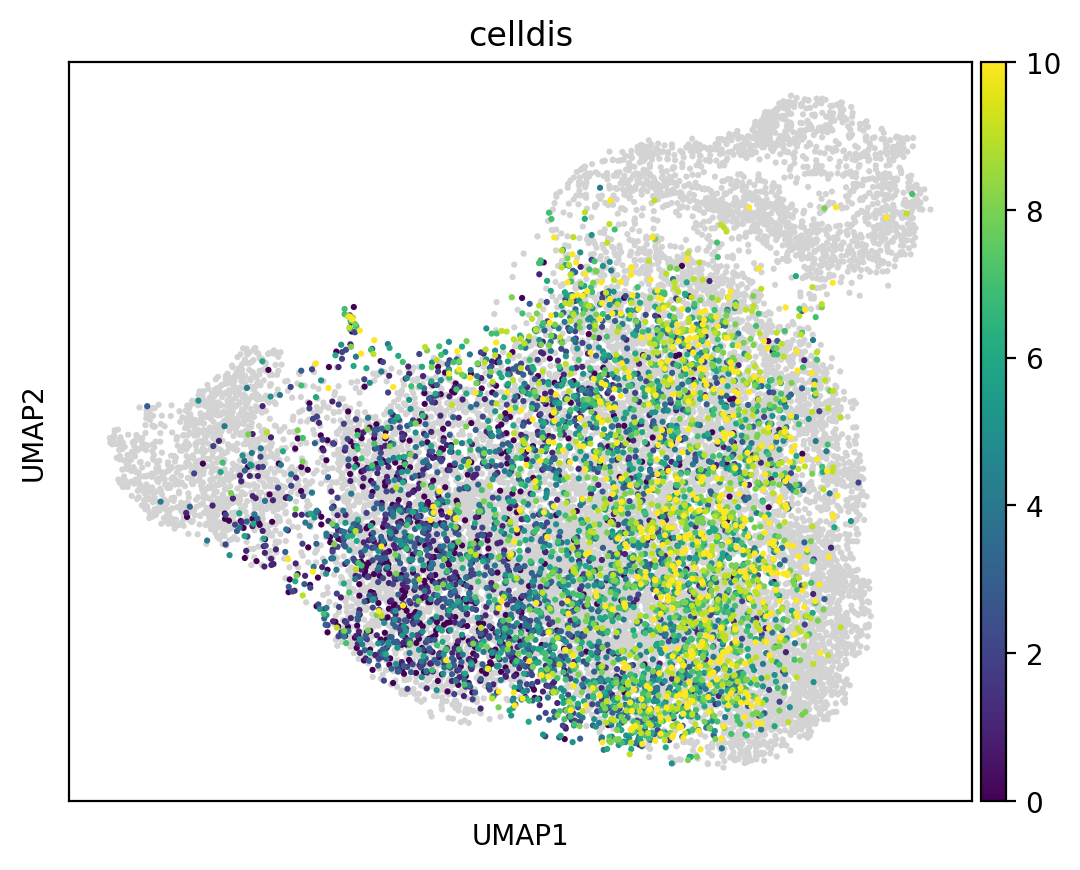

In [126]:
n_cell_types = len(np.unique(adata.obs['celltype']))  
cmap = plt.get_cmap('viridis', n_cell_types)  # Replace 'viridis' with your desired colormap  
colors = [cmap(i) for i in range(cmap.N)]
cell_type_color_map = dict(zip(np.unique(adata.obs['celltype']), colors))
cell_type_color_map['D3']='tab:red'
cell_type_color_map['D3.5']='tab:orange'
cell_type_color_map['D4']='tab:blue'
cell_type_color_map['D4.5']='tab:green'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata=adata,color="celldis", groups=list(np.unique(adata.obs['celldis'])), size=20, show=False)

<AxesSubplot:title={'center':'celltype'}, xlabel='UMAP1', ylabel='UMAP2'>

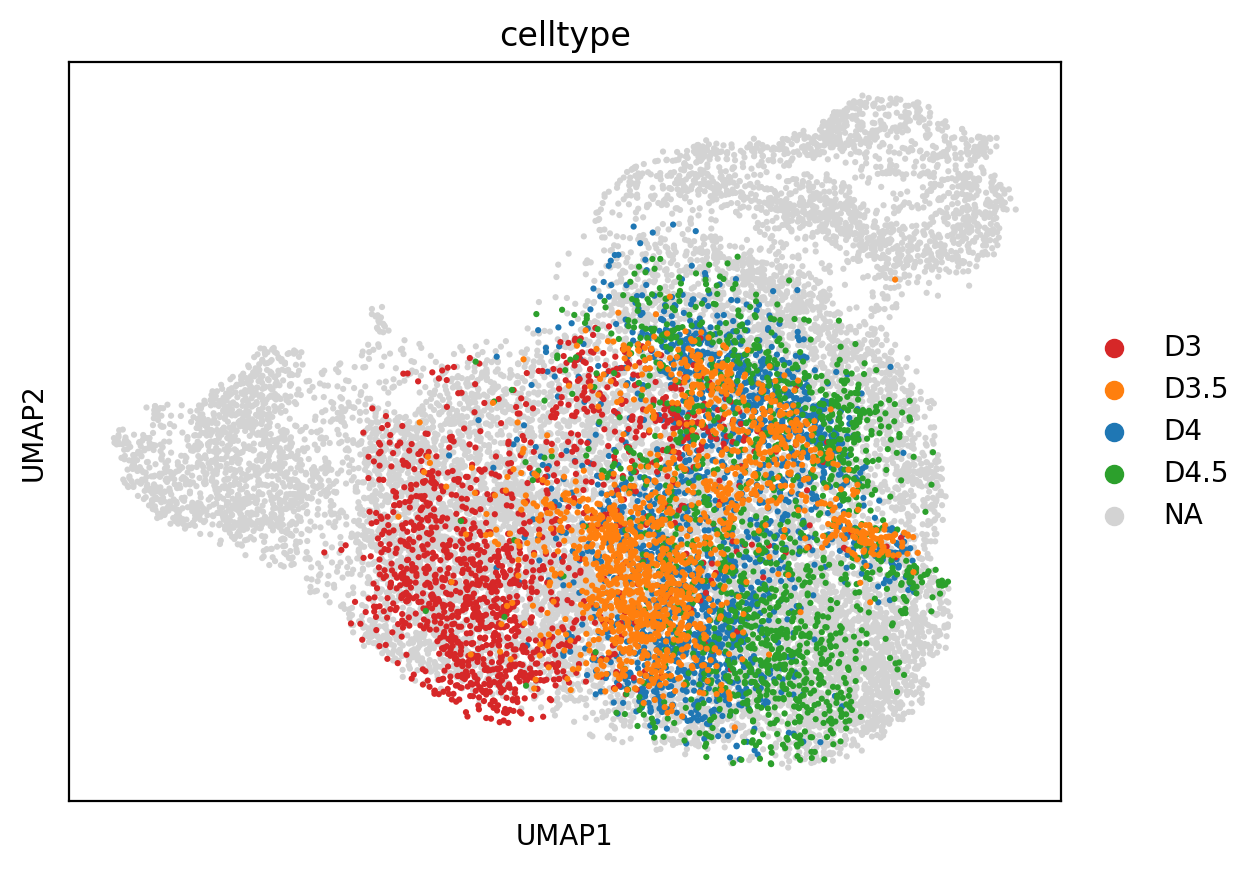

In [127]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
sc.pl.umap(adata=adata,color="celltype", groups = ['D3','D3.5','D4','D4.5'],size=20,palette=cell_type_color_map, show=False)

In [128]:
sc.tl.paga(adata, groups='celltype')
adata.uns['iroot'] = np.flatnonzero(adata.obs['celltype']  == 'D1.5')[0]
sc.tl.dpt(adata)

psudotime

In [129]:
dis_gen = []
for day in np.unique(adata.obs['celltype'].values):
    dis_mean = adata[adata.obs['celltype']==day].obs['dpt_pseudotime'].mean()
    print(day,dis_mean)
    dis_gen.append(dis_mean)

D1.5 0.28004852
D2 0.1887678
D2.5 0.05525966
D3 0.07058292
D3.5 0.11158852
D4 0.12760834
D4.5 0.13952146
D5 0.15630502
D5.5 0.16656739
D6 0.2738507
gen 0 0.07810164
gen 1 0.08986699
gen 10 0.13883732
gen 2 0.0923794
gen 3 0.098042876
gen 4 0.10775115
gen 5 0.10892196
gen 6 0.119303
gen 7 0.12616731
gen 8 0.12669285
gen 9 0.13875252
